**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Chargement des données](#toc1_1_)    
  - [Préparation des données](#toc1_2_)    
- [Approches Bag-of-words](#toc2_)    
  - [🚧 Expliquer ce que c'est](#toc2_1_)    
  - [Méthode de scoring](#toc2_2_)    
- [TF-IDF](#toc3_)    
- [CountVectorizer](#toc4_)    
- [LDA](#toc5_)    
  - [Topic → prédiction de mots](#toc5_1_)    
- [NMF](#toc6_)    
- [🚧 Conclusion](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [5]:
# OS & env
import os
import logging
import time

# DS
import numpy as np
import pandas as pd
import dill as pickle

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from Levenshtein import ratio

# home made functions from the src folder
from src.scrap_and_clean import init_data
from src.models import results_from_vec_matrix
from src.models import get_5_tags_from_matrix
from src.models import score_reduce
from src.models import plot_model
from src.models import vect_data
from src.models import get_topics
from src.models import topic_weights_df
from src.models import topic_predict

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## <a id='toc1_1_'></a>[Chargement des données](#toc0_)

In [6]:
df = init_data()

INFO:root:Loading data from http://babilobada.com/OC/2024-03-19%20QueryResults.csv...
INFO:root:✅ Raw data saved
INFO:root:Preprocessing raw data...
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:root:✅ Preprocessed data saved


In [7]:
print(f"DF shape: {df.shape}")
display(df.head())

DF shape: (50000, 10)


,Title,Body,Tags,Score,AnswerCount,CreationDate,ViewCount,title_bow,body_bow,doc_bow
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,"[ios, app-store, plist, appstore-approval, pri...",24,7,2024-03-14 22:55:18,3092,itms-91053 missing api declaration privacy,suddent getting successful builds apple,itms-91053 missing api declaration privacy sud...
1,Why is builtin sorted() slower for a list cont...,<p>I sorted four similar lists. List <code>d</...,"[python, algorithm, performance, sorting, time...",28,2,2024-03-05 15:21:50,2699,builtin sorted slower list containing descendi...,sorted four similar lists list consistently ta...,builtin sorted slower list containing descendi...
2,std::shared_mutex::unlock_shared() blocks even...,<p>My team has encountered a deadlock that I s...,"[c++, windows, multithreading, stl, shared-lock]",26,5,2024-03-01 23:09:59,1388,std :shared_mutex :unlock_shared blocks even t...,team encountered deadlock suspect bug windows ...,std :shared_mutex :unlock_shared blocks even t...
3,Did the rules for nullptr init of unique_ptr c...,<p>This code compiles with MSVC from VS 2022 i...,"[c++, visual-c++, language-lawyer, unique-ptr,...",15,1,2024-02-22 11:29:42,490,rules nullptr init unique_ptr change c++,compiles msvc c++ mode failes c++ mode current...,rules nullptr init unique_ptr change c++ compi...
4,Where is the order in which ELF relocations ar...,<p>Consider the following two files on a Linux...,"[c++, elf, dynamic-linking, abi, relocation]",16,1,2024-02-19 21:42:03,1746,order elf relocations applied specified,consider following two linux system use_messag...,order elf relocations applied specified consid...


## <a id='toc1_2_'></a>[Préparation des données](#toc0_)

Séparation de 1000 documents pour les tests, le reste pour l'entraînement des modèles

In [ ]:
random_state = 42

# isolate target
y = df["Tags"].apply(lambda x: " ".join(x)).to_list()
X_df = df.loc[:, df.columns != "Tags"]

# split entire DF for further use
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=1000, random_state=random_state
)

# then set genuine features for models
X_train = X_train_df["doc_bow"].to_list()
X_test = X_test_df["doc_bow"].to_list()

# <a id='toc2_'></a>[Approches Bag-of-words](#toc0_)

## <a id='toc2_1_'></a>[🚧 Expliquer ce que c'est](#toc0_)

## <a id='toc2_2_'></a>[Méthode de scoring](#toc0_)

On cherche à évaluer l'efficacité d'un modèle qui renvoie deux listes de termes, sans toutefois appliquer de solution binaire comme la présence ou non du terme exact dans les deux listes, au vu de la diversité des termes employés.

Un moyen simple d'utiliser le meilleur ratio de Levenshtein (similarité entre chaînes de caractères) avec un seuil cohérent et de le diviser par le nombre de termes.

> Une similarité de 70% permet par exemple de mettre une similarité de 0 entre 'c' et 'c#', une similarité de 0.71 entre 'spring' et 'spring-boot' mais de 0 entre 'spring-boot' et 'boot'.



- le score maximum de 1 équivaut à tous les termes exacts trouvés,
- le minimum de 0 signifie qu'il n'y a pas eu de terme suffisamment proche pour passer le seuil défini

In [ ]:
def score_terms(pred_words, target_words, cutoff=0.7) -> float:
    """Return a score of terms similarity between 2 lists of strings"""
    score = 0
    for p_w in pred_words:
        score += max(ratio(t, p_w, score_cutoff=cutoff) for t in target_words)
    score = np.round(score / len(pred_words), 3)

    return score

# <a id='toc3_'></a>[TF-IDF](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Un modèle simple de prédictions se basant sur les fréquences de monogrammes présents dans un corpus.

#### 🚧 Expliquer modèle

Entraînement du modèle sur l'échantillon d'entraînement

In [ ]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"\S+", min_df=10)
tfidf_fitted = tfidf_vectorizer.fit(X_train)
tfidf_names = tfidf_vectorizer.get_feature_names_out()

Exemple sur un document du test

In [ ]:
# create a random example in test set
example_doc_index = 42
doc = X_test[example_doc_index]
origin_doc = X_test_df.iloc[example_doc_index]

# get the target
y = y_test[example_doc_index].split(" ")

# predict
X = tfidf_fitted.transform(X_test)
doc_transformed = X[example_doc_index]

# display predictions
predictions = results_from_vec_matrix(tfidf_names, doc_transformed)
pred_words = [p[0] for p in predictions]

print(f"🔹 Original document:\n\t{origin_doc[['Title', 'Body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
print(f"🔹 Predictions:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

🔹 Original document:
	['Motion/Moving effect with animation on still image'
 '<p>I am trying to implement animation in a still image in a user-guided direction, something like this:</p>\n\n<p><strong>Original image</strong></p>\n\n<p><a href="https://i.stack.imgur.com/U0JTq.png" rel="noreferrer"><img src="https://i.stack.imgur.com/U0JTq.png" alt="original image"></a></p>\n\n<p><strong>Expected result</strong></p>\n\n<p><a href="https://i.stack.imgur.com/BSgEC.gif" rel="noreferrer"><img src="https://i.stack.imgur.com/BSgEC.gif" alt="expected result"></a></p>\n\n<p>For this, I have tried the <code>CIBumpDistortionLinear</code> <code>CIFilter</code>. It is animating, but the animation is not exactly like that. </p>\n\n<pre><code>let bumpDistortionLinearParams: [String: AnyObject] = [\n    kCIInputImageKey: coreImage!,\n    "inputCenter" : CIVector(string: coordStr),\n    "inputRadius": 300.0 as AnyObject,\n    "inputAngle" : 90.0 as AnyObject,\n    "inputScale" : 0.1 as AnyObject\n]\n\nle

Application sur nos données de test

In [ ]:
results = score_reduce(tfidf_names, tfidf_fitted.transform(X_test), y_test)

# check with sample
print("Check with example sample")
print(results[1][example_doc_index])
print(results[2][example_doc_index])

Score:  0.232 - Duration:  11.0
Check with example sample
['animation', 'image', 'animating', 'still', 'direction']
0.157


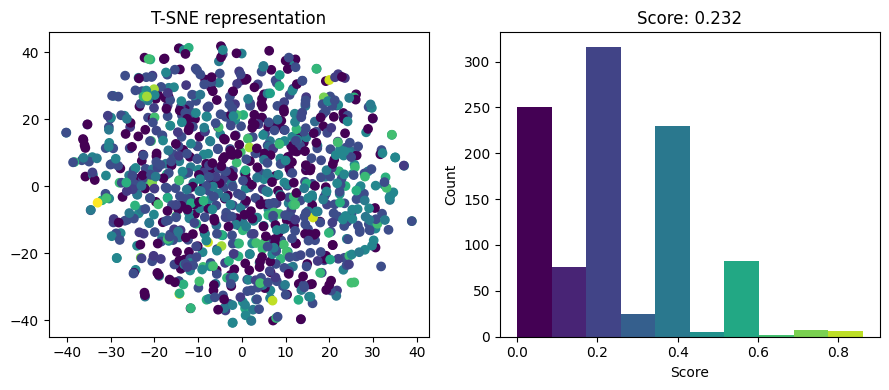

In [ ]:
plot_model(results[0], results[2], results[3])

De par son fonctionnement, **TF-IDF ne propose pas les tags les plus fréquents**, tels que les noms de langages informatiques ou bibliothèques régulièrement utilisées : c'est là une des limites de cette approche simple.

# <a id='toc4_'></a>[CountVectorizer](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

#### 🚧 Expliquer modèle

Modèle de comptage vectoriel avec au moins 10 occurrences dans le corpus :

In [ ]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)

Entraînement

In [ ]:
cv_fitted = count_vectorizer.fit(X_train)
cv_names = count_vectorizer.get_feature_names_out()

Résultats sur l'échantillon de test

Score:  0.197 - Duration:  13.0


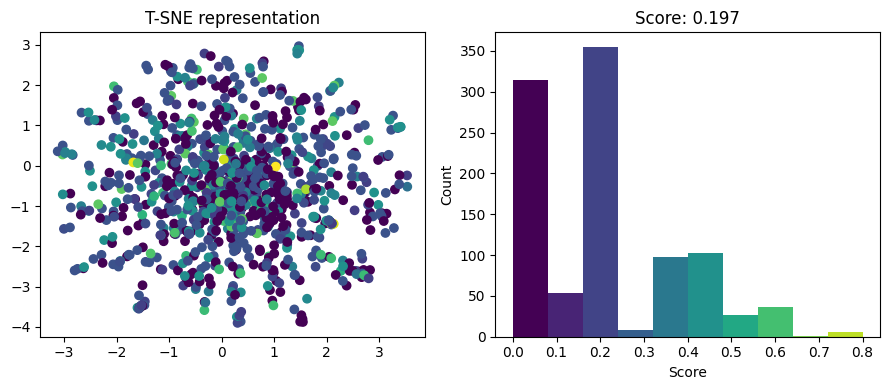

In [ ]:
results = score_reduce(cv_names, cv_fitted.transform(X_test), y_test)
plot_model(results[0], results[2], results[3])

# <a id='toc5_'></a>[LDA](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

[pyLDAvis for visualization](https://medium.com/@sherryqixuan/topic-modeling-and-pyldavis-visualization-86a543e21f58)

[LDA Gensim 1](https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation)
[LDA Gensim 2](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel)

[❤️ LDA in TDS](https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd)

#### 🚧 Expliquer modèle

Modèle LDA avec 20 topics

In [ ]:
# define a maximum number of topics (each represented by some words)
n_topics = 20

# LDA model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=random_state,
)

LDA prend une matrice de vecteurs en entrée : utilisation de CountVectorizer

In [ ]:
cv = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)
cv_data = cv.fit_transform(X_train)
cv_names = cv.get_feature_names_out()

Entraînement

In [ ]:
lda.fit(cv_data)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=42)

Affichage des topics

In [ ]:
n_top_words = 10
topics = get_topics(lda, cv_names, n_top_words)
topics

['number time data model size performance array function one two',
 'function type c++ following class compiler example functions types variable',
 'python install installed script package packages rails mac version pip',
 'api server user request client service get http token access',
 'list text column get dataframe values pandas tried data way',
 "tried get version 've problem following working app project also",
 "one way time question first 've problem seems also case",
 'test command running windows tests docker container environment server unit',
 'page component react html lambda load aws components function css',
 'database table query sql select maven laravel name mysql task',
 'view button click bar layout event change navigation custom screen',
 'quot core project library .net studio visual asp.net framework application',
 'app android ios device video studio flutter window background screen',
 'module project import folder path build directory webpack modules certificate',

Application aux données de test

In [ ]:
# predict
X_cv = cv.transform(X_test)
X_lda = lda.transform(X_cv)

Essai sur un exemple

In [ ]:
n_top_topics = 5  # best topics for each input

# create a random example in test set
example_doc_index = 42
doc = X_test[example_doc_index]
origin_doc = X_test_df.iloc[example_doc_index]

# get the n top topics
top_topics = X_lda[example_doc_index].argsort()[: -n_top_topics - 1 : -1]
# get its weights
top_topics_weights = X_lda[example_doc_index][top_topics]

print(f"🔹 Original document:\n\t{origin_doc[['Title', 'Body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
# predict topics
print(f"🔹 Top {n_top_topics} topics:")
for topic in top_topics:
    print(
        f"\tTopic {topic} (weight {X_lda[example_doc_index][topic]}):\n\t\t{topics[topic]}"
    )

🔹 Original document:
	['Motion/Moving effect with animation on still image'
 '<p>I am trying to implement animation in a still image in a user-guided direction, something like this:</p>\n\n<p><strong>Original image</strong></p>\n\n<p><a href="https://i.stack.imgur.com/U0JTq.png" rel="noreferrer"><img src="https://i.stack.imgur.com/U0JTq.png" alt="original image"></a></p>\n\n<p><strong>Expected result</strong></p>\n\n<p><a href="https://i.stack.imgur.com/BSgEC.gif" rel="noreferrer"><img src="https://i.stack.imgur.com/BSgEC.gif" alt="expected result"></a></p>\n\n<p>For this, I have tried the <code>CIBumpDistortionLinear</code> <code>CIFilter</code>. It is animating, but the animation is not exactly like that. </p>\n\n<pre><code>let bumpDistortionLinearParams: [String: AnyObject] = [\n    kCIInputImageKey: coreImage!,\n    "inputCenter" : CIVector(string: coordStr),\n    "inputRadius": 300.0 as AnyObject,\n    "inputAngle" : 90.0 as AnyObject,\n    "inputScale" : 0.1 as AnyObject\n]\n\nle

La visualisation des topics est efficace mais on souhaite la prédiction de 5 tags à partir des topics.

## <a id='toc5_1_'></a>[Topic → prédiction de mots](#toc0_)

Pour cela, il est possible de pondérer le poids de chacun des 10 meilleurs mots d'un topic par la probabilité du topic lui-même, puis de récupérer les 5 meilleurs mots qui en ressortent.

Pour chaque topic, sauvegarde des 10 meilleurs poids et mots associés dans un dataframe :

In [ ]:
lda_df = topic_weights_df(lda, cv_names)
lda_df.head()

,topic,index,word,weight
0,0,5968,number,2564.763823
1,0,9056,time,2146.563200
2,0,2258,data,2120.487002
3,0,5579,model,1907.152385
4,0,8166,size,1783.984799


Prédictions pour l'échantillon de test

In [ ]:
X_results = [topic_predict(lda_df, xi) for xi in X_lda]

Sur le document d'exemple

In [ ]:
pred_words = X_results[example_doc_index][1]
y = y_test[example_doc_index]

print(f"🔹 Words prediction:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

🔹 Words prediction:
	['view', 'image', 'one', 'button', 'way']

🔹 Targetted tags:
	ios swift core-animation core-image glkit

🔹 Score:
	0.0



Résultats sur l'échantillon de test

Score:  0.039 - Duration:  17.0


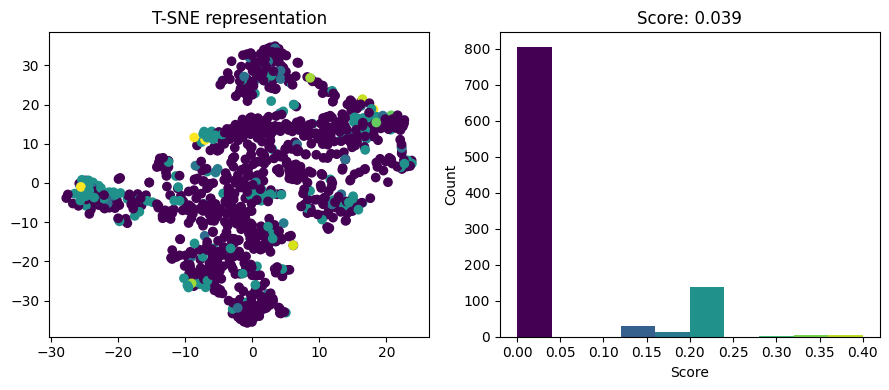

In [ ]:
results = score_reduce(cv_names, X_lda, y_test, model_type="topic", model=lda)
plot_model(results[0], results[2], results[3])

# <a id='toc6_'></a>[NMF](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

#### 🚧 Expliquer modèle

In [ ]:
# define a maximum number of topics (each represented by some words)
n_topics = 20

nmf = NMF(n_components=n_topics)

NMF prend une matrice de vecteurs en entrée : utilisation de TF-IDF

In [ ]:
tfidf = TfidfVectorizer(token_pattern=r"\S+", min_df=10)
tfidf_data = tfidf.fit_transform(X_train)
tfidf_names = tfidf.get_feature_names_out()

Entraînement

In [ ]:
nmf.fit(tfidf_data)

/home/vscode/.env/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=20)

In [ ]:
n_top_words = 10
topics = get_topics(nmf, tfidf_names, n_top_words)
topics

["one way time 've question two example memory different also",
 'project build module version package install following tried folder command',
 'request api server token client response user http get authentication',
 'test tests unit mock testing jest junit component coverage write',
 'component page button react view html text angular css chrome',
 'python install windows installed pip script environment anaconda version selenium',
 'quot failed new https c line warning import string name',
 'dataframe column pandas columns row values spark rows pyspark convert',
 'spring boot application security jpa configuration rest java bean controller',
 'core .net asp.net framework web visual application project mvc studio',
 'image images upload size color background opencv text convert camera',
 'android studio gradle visual device emulator build sdk kotlin plugin',
 'xcode ios swift view simulator beta iphone device apple framework',
 'type c++ gcc types clang compiler template value follo

Pour chaque topic, sauvegarde des 10 meilleurs poids et mots associés dans un dataframe :

In [ ]:
nmf_df = topic_weights_df(nmf, tfidf_names)
nmf_df.head()

,topic,index,word,weight
0,0,6072,one,1.760795
1,0,9813,way,1.330700
2,0,9056,time,1.299880
3,0,70,'ve,1.060341
4,0,7024,question,1.055157


Application aux données de test

In [ ]:
# predict
X_tfidf = tfidf.transform(X_test)
X_nmf = nmf.transform(X_tfidf)

Prédictions pour l'échantillon de test

In [ ]:
X_results = [topic_predict(nmf_df, xi) for xi in X_nmf]

Sur le document d'exemple

In [ ]:
pred_words = X_results[example_doc_index][1]
y = y_test[example_doc_index]

print(f"🔹 Words prediction:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

🔹 Words prediction:
	['image', 'images', 'upload', 'size', 'color']

🔹 Targetted tags:
	ios swift core-animation core-image glkit

🔹 Score:
	0.0



Résultats sur l'échantillon de test

Score:  0.11 - Duration:  17.0


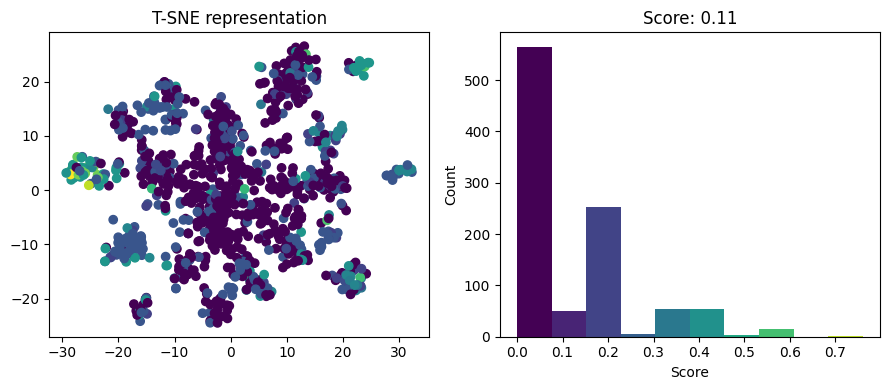

In [ ]:
results = score_reduce(tfidf_names, X_nmf, y_test, model_type="topic", model=nmf)
plot_model(results[0], results[2], results[3])

# <a id='toc7_'></a>[🚧 Conclusion](#toc0_)